In [ ]:
# preliminaries 
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"kylehammerberg","key":"90acae4f03189d8a004a02d236a8e4da"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                             title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ruchi798/data-science-job-salaries                              Data Science Job Salaries                        7KB  2022-06-15 08:59:12          21154        651  1.0              
josephcheng123456/olympic-historical-dataset-from-olympediaorg  Olympic Historical Dataset From Olympedia.org   25MB  2022-08-18 14:18:14            665         27  1.0              
deepcontractor/mcdonalds-india-menu-nutrition-facts             McDonald's India : Menu Nutrition Dataset        5KB  2022-07-28 17:08:52           1694         90  0.9411765        
gpreda/life-expectancy-in-europe-by-age-and-sex                 Life Expectancy in Eu

In [ ]:
! kaggle competitions download -c big-data-derby-2022


 94% 174M/185M [00:00<00:00, 210MB/s]
100% 185M/185M [00:00<00:00, 201MB/s]


In [ ]:
!unzip big-data-derby-2022.zip -d derby_data

Archive:  big-data-derby-2022.zip
  inflating: derby_data/nyra_2019_complete.csv  
  inflating: derby_data/nyra_race_table.csv  
  inflating: derby_data/nyra_start_table.csv  
  inflating: derby_data/nyra_tracking_table.csv  


In [ ]:
# install coordinate conversions 
!pip install pymap3d
import pymap3d as pm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.6 MB/s 


In [ ]:
# few friends of mine to get this party started
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
import plotly.express as px #graphing
import plotly.graph_objects as go #graphing
from plotly.subplots import make_subplots #graphing
import plotly.figure_factory as ff #graphing

sns.set_theme(palette="pastel")

from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected=True)

plt.rcParams["figure.figsize"] = (12, 8)

warnings.filterwarnings('ignore')
%matplotlib inline

df is the combined file into one table

All 3 non-df tables contain track_id, race_date, and race_number 

The **race table** contains information about the individual races. Course type, track condition, run up distance, race type, purse, and and the time of day that the race began (1220 = 12:20PM) 

The **tracking table** has the horse in the race, the trakus index that measures where a horse is on the track every .25 seconds along with the latitude and longitutde of the horse in the race 

The **start table** contains the horse ID number, the weight carried by the horse, the jockey, and the odds 

In [ ]:
from pandas.io.formats.format import DataFrameFormatter

# read in the data
race_table = pd.read_csv('/content/derby_data/nyra_race_table.csv')
start_table = pd.read_csv('/content/derby_data/nyra_start_table.csv')
tracking_table = pd.read_csv('/content/derby_data/nyra_tracking_table.csv')

In [ ]:
# combined table of three above files

# passing dtype directly to pandas reduces memory usage 

dtype_dict = {"track_id": object ,
              #"race_date" : will be read with "parse_dates" parameter
              "race_number" : np.int8, 
              "program_number" : object,
              "trakus_index" : np.int16,  
              "latitude" : np.float64,
              "longitude" : np.float64,
              "distance_id" : np.int16,  
              "course_type" : object, 
              "track_condition" : object,
              "run_up_distance" : np.int8,  
              "race_type" : object, 
              "purse" : np.int32,  
              "post_time" : np.int16,  
              "weight_carried" : np.int16,  
              "jockey" : object, 
              "odds" : np.int16,
             }

df = pd.read_csv('/content/derby_data/nyra_2019_complete.csv', 
                 dtype = dtype_dict, parse_dates=["race_date"])
display(df.info())

df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5228430 entries, 0 to 5228429
Data columns (total 17 columns):
 #   Column           Dtype         
---  ------           -----         
 0   track_id         object        
 1   race_date        datetime64[ns]
 2   race_number      int8          
 3   program_number   object        
 4   trakus_index     int16         
 5   latitude         float64       
 6   longitude        float64       
 7   distance_id      int16         
 8   course_type      object        
 9   track_condition  object        
 10  run_up_distance  int8          
 11  race_type        object        
 12  purse            int32         
 13  post_time        int16         
 14  weight_carried   int16         
 15  jockey           object        
 16  odds             int16         
dtypes: datetime64[ns](1), float64(2), int16(5), int32(1), int8(2), object(6)
memory usage: 438.8+ MB


None

,track_id,race_date,race_number,program_number,trakus_index,latitude,longitude,distance_id,course_type,track_condition,run_up_distance,race_type,purse,post_time,weight_carried,jockey,odds
0,AQU,2019-01-01,9,6,72,40.672902,-73.827607,600,D,GD,48,CLM,25000,420,120,Andre Shivnarine Worrie,2090
1,AQU,2019-01-01,9,6,73,40.672946,-73.827587,600,D,GD,48,CLM,25000,420,120,Andre Shivnarine Worrie,2090
2,AQU,2019-01-01,9,6,74,40.672990,-73.827568,600,D,GD,48,CLM,25000,420,120,Andre Shivnarine Worrie,2090
3,AQU,2019-01-01,9,6,63,40.672510,-73.827781,600,D,GD,48,CLM,25000,420,120,Andre Shivnarine Worrie,2090
4,AQU,2019-01-01,9,6,64,40.672553,-73.827762,600,D,GD,48,CLM,25000,420,120,Andre Shivnarine Worrie,2090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5228425,AQU,2019-11-23,9,2,167,40.672363,-73.830853,1100,T,GD,72,STK,200000,353,124,Joel Rosario,1120
5228426,AQU,2019-11-23,9,2,168,40.672321,-73.830873,1100,T,GD,72,STK,200000,353,124,Joel Rosario,1120
5228427,AQU,2019-11-23,9,2,169,40.672281,-73.830893,1100,T,GD,72,STK,200000,353,124,Joel Rosario,1120
5228428,AQU,2019-11-23,9,2,170,40.672240,-73.830913,1100,T,GD,72,STK,200000,353,124,Joel Rosario,1120


In [ ]:
# checking race data
display(race_table.info())

race_table

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   track_id         2000 non-null   object
 1   race_date        2000 non-null   object
 2   race_number      2000 non-null   int64 
 3   distance_id      2000 non-null   int64 
 4   course_type      2000 non-null   object
 5   track_condition  2000 non-null   object
 6   run_up_distance  2000 non-null   int64 
 7   race_type        2000 non-null   object
 8   purse            2000 non-null   int64 
 9   post_time        2000 non-null   int64 
dtypes: int64(5), object(5)
memory usage: 156.4+ KB


None

,track_id,race_date,race_number,distance_id,course_type,track_condition,run_up_distance,race_type,purse,post_time
0,AQU,2019-01-01,1,650,D,MY,36,AOC,80000,1220
1,AQU,2019-01-01,2,600,D,MY,48,MCL,41000,1250
2,AQU,2019-01-01,3,550,D,MY,54,MCL,35000,121
3,AQU,2019-01-01,4,900,D,MY,101,AOC,80000,150
4,AQU,2019-01-01,5,700,D,MY,60,ALW,64000,220
...,...,...,...,...,...,...,...,...,...,...
1995,SAR,2019-09-02,7,900,D,SY,79,CLM,48000,356
1996,SAR,2019-09-02,8,700,D,SY,32,AOC,83000,433
1997,SAR,2019-09-02,9,850,I,SF,22,STK,250000,507
1998,SAR,2019-09-02,10,700,D,SY,32,STK,350000,540


2000 total unique race IDs 

In [ ]:
# checking tracking table 
display(tracking_table.info())

tracking_table

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5228430 entries, 0 to 5228429
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   track_id        object 
 1   race_date       object 
 2   race_number     int64  
 3   program_number  object 
 4   trakus_index    int64  
 5   latitude        float64
 6   longitude       float64
dtypes: float64(2), int64(2), object(3)
memory usage: 279.2+ MB


None

,track_id,race_date,race_number,program_number,trakus_index,latitude,longitude
0,AQU,2019-01-01,9,6,72,40.672902,-73.827607
1,AQU,2019-01-01,9,6,73,40.672946,-73.827587
2,AQU,2019-01-01,9,6,74,40.672990,-73.827568
3,AQU,2019-01-01,9,6,63,40.672510,-73.827781
4,AQU,2019-01-01,9,6,64,40.672553,-73.827762
...,...,...,...,...,...,...,...
5228425,AQU,2019-11-23,9,2,167,40.672363,-73.830853
5228426,AQU,2019-11-23,9,2,168,40.672321,-73.830873
5228427,AQU,2019-11-23,9,2,169,40.672281,-73.830893
5228428,AQU,2019-11-23,9,2,170,40.672240,-73.830913


In [ ]:
# checking combined df
display(df.info())

df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5228430 entries, 0 to 5228429
Data columns (total 17 columns):
 #   Column           Dtype         
---  ------           -----         
 0   track_id         object        
 1   race_date        datetime64[ns]
 2   race_number      int8          
 3   program_number   object        
 4   trakus_index     int16         
 5   latitude         float64       
 6   longitude        float64       
 7   distance_id      int16         
 8   course_type      object        
 9   track_condition  object        
 10  run_up_distance  int8          
 11  race_type        object        
 12  purse            int32         
 13  post_time        int16         
 14  weight_carried   int16         
 15  jockey           object        
 16  odds             int16         
dtypes: datetime64[ns](1), float64(2), int16(5), int32(1), int8(2), object(6)
memory usage: 438.8+ MB


None

,track_id,race_date,race_number,program_number,trakus_index,latitude,longitude,distance_id,course_type,track_condition,run_up_distance,race_type,purse,post_time,weight_carried,jockey,odds
0,AQU,2019-01-01,9,6,72,40.672902,-73.827607,600,D,GD,48,CLM,25000,420,120,Andre Shivnarine Worrie,2090
1,AQU,2019-01-01,9,6,73,40.672946,-73.827587,600,D,GD,48,CLM,25000,420,120,Andre Shivnarine Worrie,2090
2,AQU,2019-01-01,9,6,74,40.672990,-73.827568,600,D,GD,48,CLM,25000,420,120,Andre Shivnarine Worrie,2090
3,AQU,2019-01-01,9,6,63,40.672510,-73.827781,600,D,GD,48,CLM,25000,420,120,Andre Shivnarine Worrie,2090
4,AQU,2019-01-01,9,6,64,40.672553,-73.827762,600,D,GD,48,CLM,25000,420,120,Andre Shivnarine Worrie,2090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5228425,AQU,2019-11-23,9,2,167,40.672363,-73.830853,1100,T,GD,72,STK,200000,353,124,Joel Rosario,1120
5228426,AQU,2019-11-23,9,2,168,40.672321,-73.830873,1100,T,GD,72,STK,200000,353,124,Joel Rosario,1120
5228427,AQU,2019-11-23,9,2,169,40.672281,-73.830893,1100,T,GD,72,STK,200000,353,124,Joel Rosario,1120
5228428,AQU,2019-11-23,9,2,170,40.672240,-73.830913,1100,T,GD,72,STK,200000,353,124,Joel Rosario,1120


In [ ]:
# check for duplicates
df.shape, df.drop_duplicates().shape

((5228430, 17), (5228430, 17))

shape 1 = shape 2 .... no duplicates present. 🙂

In [ ]:
features = {}
for i in df.columns.to_list(): 
    features[i]=len(df[i].unique())
features

{'track_id': 3,
 'race_date': 217,
 'race_number': 13,
 'program_number': 20,
 'trakus_index': 1062,
 'latitude': 5224784,
 'longitude': 5224799,
 'distance_id': 20,
 'course_type': 5,
 'track_condition': 7,
 'run_up_distance': 126,
 'race_type': 12,
 'purse': 70,
 'post_time': 360,
 'weight_carried': 35,
 'jockey': 178,
 'odds': 656}

In [ ]:

%%time
# quick changes to program numbers... homogenize formatting for all horses 
df['program_number'] = df['program_number'].replace(r'1A','17',regex=True)
df['program_number'] = df['program_number'].replace(r'1X','18',regex=True)
df['program_number'] = df['program_number'].replace(r'2B','19',regex=True)
df['program_number'] = df['program_number'].replace(r'3X','20',regex=True)

df

CPU times: user 27.3 s, sys: 53.4 ms, total: 27.3 s
Wall time: 27.4 s


,track_id,race_date,race_number,program_number,trakus_index,latitude,longitude,distance_id,course_type,track_condition,run_up_distance,race_type,purse,post_time,weight_carried,jockey,odds
0,AQU,2019-01-01,9,6,72,40.672902,-73.827607,600,D,GD,48,CLM,25000,420,120,Andre Shivnarine Worrie,2090
1,AQU,2019-01-01,9,6,73,40.672946,-73.827587,600,D,GD,48,CLM,25000,420,120,Andre Shivnarine Worrie,2090
2,AQU,2019-01-01,9,6,74,40.672990,-73.827568,600,D,GD,48,CLM,25000,420,120,Andre Shivnarine Worrie,2090
3,AQU,2019-01-01,9,6,63,40.672510,-73.827781,600,D,GD,48,CLM,25000,420,120,Andre Shivnarine Worrie,2090
4,AQU,2019-01-01,9,6,64,40.672553,-73.827762,600,D,GD,48,CLM,25000,420,120,Andre Shivnarine Worrie,2090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5228425,AQU,2019-11-23,9,2,167,40.672363,-73.830853,1100,T,GD,72,STK,200000,353,124,Joel Rosario,1120
5228426,AQU,2019-11-23,9,2,168,40.672321,-73.830873,1100,T,GD,72,STK,200000,353,124,Joel Rosario,1120
5228427,AQU,2019-11-23,9,2,169,40.672281,-73.830893,1100,T,GD,72,STK,200000,353,124,Joel Rosario,1120
5228428,AQU,2019-11-23,9,2,170,40.672240,-73.830913,1100,T,GD,72,STK,200000,353,124,Joel Rosario,1120


### Now that we've done some of the preliminary feature engineering and read in the data, let's put together some visualizations. 



In [ ]:
df['course_type'].value_counts()

D    3229234
T     988274
I     752310
O     193063
M      65549
Name: course_type, dtype: int64

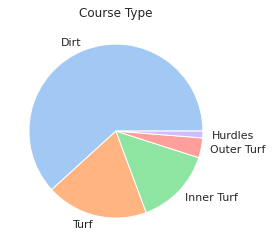

In [ ]:
labels_ct = ['Dirt','Turf', 'Inner Turf', 'Outer Turf', 'Hurdles']

plt.title('Course Type')
plt.pie(df['course_type'].value_counts(), labels=labels_ct)
plt.show()

In [ ]:
df['track_condition'].value_counts()

FT     2345748
FM     1391865
GD      733124
SY      486795
MY      172943
YL       89250
SF        8705
Name: track_condition, dtype: int64

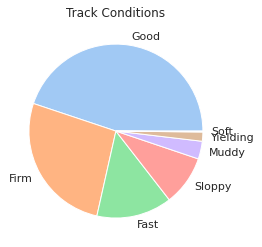

In [ ]:
labels_tc = ['Good', 'Firm', 'Fast', 'Sloppy', 'Muddy','Yielding', 'Soft']

plt.title('Track Conditions')
plt.pie(df['track_condition'].value_counts(), labels=labels_tc)
plt.show()


In [ ]:
# create log transform of odds column (scale up by 1 because 0 values with 0 for odds)
df['log_odds'] = np.log(df['odds']+1)

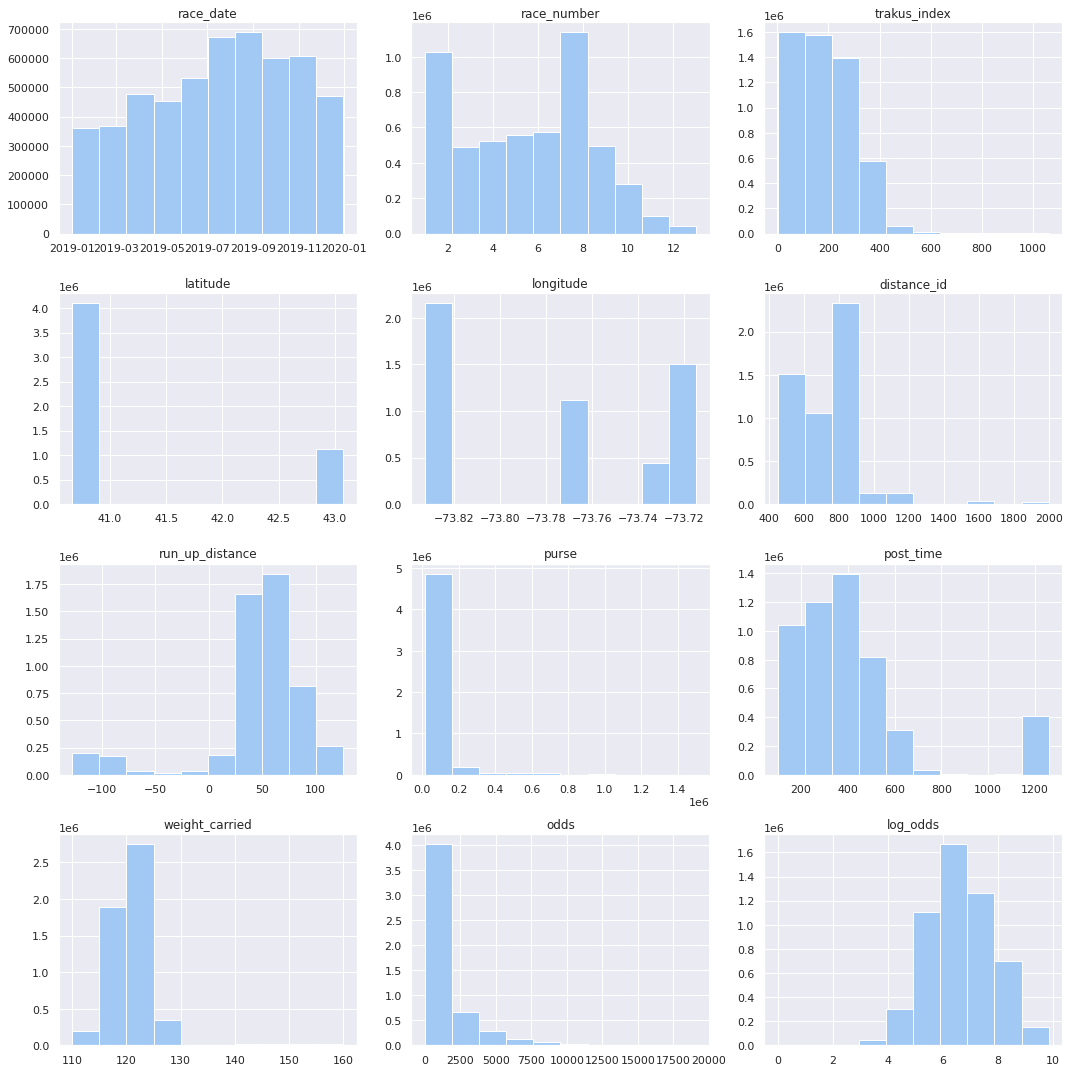

In [ ]:
# histograms of data
df.hist(figsize=(15,15))
plt.tight_layout()
plt.show()

Let's take a closer look at some of the data associated with program number (aka horse ID) 

In [ ]:
# plot of odds relative to weight carried with horse ID specified by color 
fig = px.scatter(start_table, x="odds", y="weight_carried", color="program_number", width=1000)
fig.show(renderer="colab")

In [ ]:
# checking top values sorted for weight 
wt_df = start_table.sort_values('weight_carried', ascending=False)
wt_df.head(n=75)

,track_id,race_date,race_number,program_number,weight_carried,jockey,odds
9963,BEL,2019-09-19,1,9,160,Thomas Garner,90
9955,BEL,2019-09-19,1,1,158,Sean McDermott,650
12359,SAR,2019-07-24,1,1,156,Thomas Garner,325
12365,SAR,2019-07-24,1,6,156,Michael Mitchell,560
14415,SAR,2019-08-28,1,3,156,Ross Geraghty,75
...,...,...,...,...,...,...,...
12440,SAR,2019-07-25,1,1,142,William McCarthy,3325
9961,BEL,2019-09-19,1,7,142,Gerard Galligan,4825
9962,BEL,2019-09-19,1,8,142,Bernard Dalton,3525
5428,AQU,2019-12-08,9,3,132,Tyler Gaffalione,50


There's a distinct separation in weight_carried. Most values occur below ~127 pounds and then there's a distinct group above ~141 pounds. Let's see if we can figure what that's about. First, let's set up some conditionals to see if there was specific days these heavy weight competed

In [ ]:
# big guys 
fig = px.scatter(start_table[start_table['weight_carried'] > 135], x="race_date", y="weight_carried", color="program_number", width=1000)
fig.show(renderer="colab")

We can see that there was a distinct interval of time where these heavyweight races took place. Let's try the same scatter plot as above but use color to identify race location (track_id) 

In [ ]:
# plot of odds relative to weight carried with horse ID specified by color 
fig = px.scatter(start_table, x="odds", y="weight_carried", color="track_id", width=1000)
fig.show(renderer="colab")

So, obviously these were specific races that were specific to the heavy weights. Let's see if I can identify qualities of those specific races. 

In [ ]:
wt_date_df = df[(df['race_date'] > '2019-07-25') & (df['race_number']==1)].sort_values('weight_carried', ascending=False)
wt_date_df

,track_id,race_date,race_number,program_number,trakus_index,latitude,longitude,distance_id,course_type,track_condition,run_up_distance,race_type,purse,post_time,weight_carried,jockey,odds
5163991,BEL,2019-09-19,1,9,911,40.714374,-73.724691,2000,M,FM,0,STK,150000,304,160,Thomas Garner,90
5164168,BEL,2019-09-19,1,9,728,40.716476,-73.722253,2000,M,FM,0,STK,150000,304,160,Thomas Garner,90
5164182,BEL,2019-09-19,1,9,718,40.716353,-73.721767,2000,M,FM,0,STK,150000,304,160,Thomas Garner,90
5164181,BEL,2019-09-19,1,9,717,40.716341,-73.721719,2000,M,FM,0,STK,150000,304,160,Thomas Garner,90
5164180,BEL,2019-09-19,1,9,716,40.716330,-73.721678,2000,M,FM,0,STK,150000,304,160,Thomas Garner,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3526774,BEL,2019-09-07,1,6,266,40.712982,-73.721661,600,D,FT,63,ALW,66000,103,112,Benjamin Hernandez,1820
3526775,BEL,2019-09-07,1,6,267,40.712970,-73.721611,600,D,FT,63,ALW,66000,103,112,Benjamin Hernandez,1820
3526776,BEL,2019-09-07,1,6,268,40.712957,-73.721560,600,D,FT,63,ALW,66000,103,112,Benjamin Hernandez,1820
3526777,BEL,2019-09-07,1,6,269,40.712944,-73.721509,600,D,FT,63,ALW,66000,103,112,Benjamin Hernandez,1820


One thing we know is that weight carried is only in excess of 132 in races in Bel and Sar. I did a further, external investigation into the amount of weight horses carry during races and found that sometimes horses that are outliers in terms of performance will be given additional weight that's determined via a handidcap system to ensure a fair race. This tells us that higher weighted horses are stronger competitors. Noting which horses are weighted in some races should come in handy for predicting race outcomes. This also explains why they have better odds despite carrying more weight. 

In [ ]:
# checking top values sorted for weight 
wt2_df = df[df['weight_carried'] > 135].sort_values('weight_carried', ascending=False)
wt2_df

,track_id,race_date,race_number,program_number,trakus_index,latitude,longitude,distance_id,course_type,track_condition,run_up_distance,race_type,purse,post_time,weight_carried,jockey,odds
5164021,BEL,2019-09-19,1,9,881,40.714796,-73.726263,2000,M,FM,0,STK,150000,304,160,Thomas Garner,90
5164317,BEL,2019-09-19,1,9,577,40.713053,-73.718978,2000,M,FM,0,STK,150000,304,160,Thomas Garner,90
5164308,BEL,2019-09-19,1,9,592,40.713402,-73.718238,2000,M,FM,0,STK,150000,304,160,Thomas Garner,90
5164309,BEL,2019-09-19,1,9,593,40.713434,-73.718198,2000,M,FM,0,STK,150000,304,160,Thomas Garner,90
5164310,BEL,2019-09-19,1,9,594,40.713468,-73.718160,2000,M,FM,0,STK,150000,304,160,Thomas Garner,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5022379,BEL,2019-09-19,1,5,844,40.715851,-73.727505,2000,M,FM,0,STK,150000,304,142,Graham Watters,4325
5022380,BEL,2019-09-19,1,5,845,40.715810,-73.727499,2000,M,FM,0,STK,150000,304,142,Graham Watters,4325
5022381,BEL,2019-09-19,1,5,834,40.716284,-73.727466,2000,M,FM,0,STK,150000,304,142,Graham Watters,4325
5022382,BEL,2019-09-19,1,5,835,40.716242,-73.727478,2000,M,FM,0,STK,150000,304,142,Graham Watters,4325


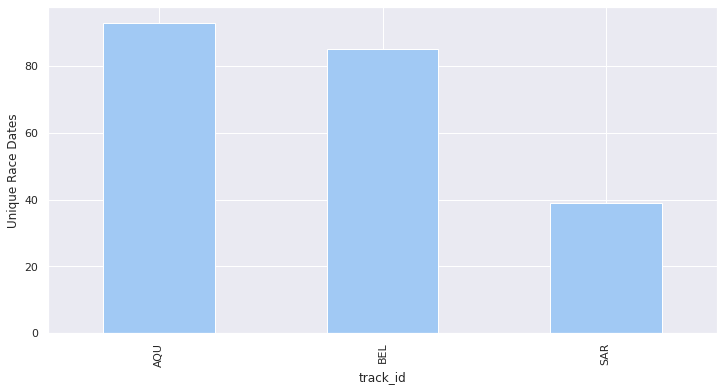

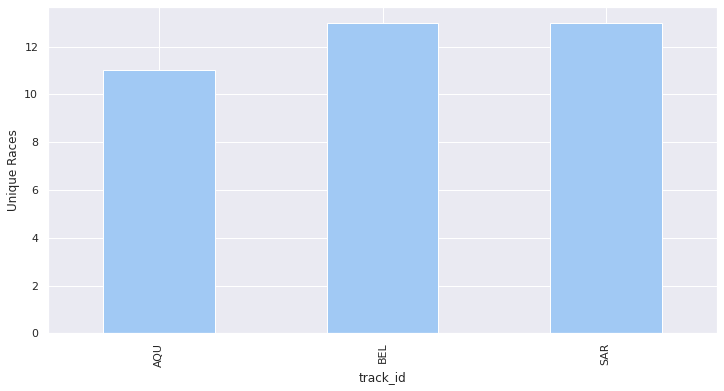

In [ ]:
# plots of unique race dates per track id & unique races per track_id

fig, ax = plt.subplots(1,1, figsize=(12,6))
(start_table.groupby("track_id").race_date.nunique()).plot(kind="bar")
ax.set_ylabel("Unique Race Dates")


fig, ax = plt.subplots(1,1, figsize=(12,6))
(start_table.groupby("track_id")["race_number"].nunique()).plot(kind="bar")
ax.set_ylabel("Unique Races")


plt.show()

Let's generate some box plots to see how purse, odds, distance, weight carried, and run_up_distance are distributed  

In [ ]:
# checking purse distribution 
fig = px.histogram(race_table, x="purse", template="simple_white")
fig.show(renderer="colab")

Vast majority of events have purse below 250k 

# Let's have a look at the three tracks. We will subset a month of data for each track and build a scatterplot with the longitude and latitude points 

In [ ]:
# create new cols for month and day of races
tracking_table['race_date'] = pd.to_datetime(tracking_table['race_date'])
tracking_table['day'], tracking_table['month'] = tracking_table['race_date'].dt.day, tracking_table['race_date'].dt.month

In [ ]:
bel_track

,track_id,race_date,race_number,program_number,trakus_index,latitude,longitude,day,month
845,BEL,2019-06-09,6,6,1,40.715684,-73.719632,9,6
846,BEL,2019-06-09,6,6,2,40.715686,-73.719641,9,6
847,BEL,2019-06-09,6,6,3,40.715689,-73.719655,9,6
848,BEL,2019-06-09,6,6,4,40.715693,-73.719668,9,6
849,BEL,2019-06-09,6,6,5,40.715698,-73.719690,9,6
...,...,...,...,...,...,...,...,...,...
5215984,BEL,2019-06-07,10,8,8,40.716709,-73.721897,7,6
5215985,BEL,2019-06-07,10,8,9,40.716717,-73.721927,7,6
5215986,BEL,2019-06-07,10,8,10,40.716725,-73.721957,7,6
5215987,BEL,2019-06-07,10,8,11,40.716733,-73.721988,7,6


In [ ]:
# plot belmont race number 6 with hue representing 

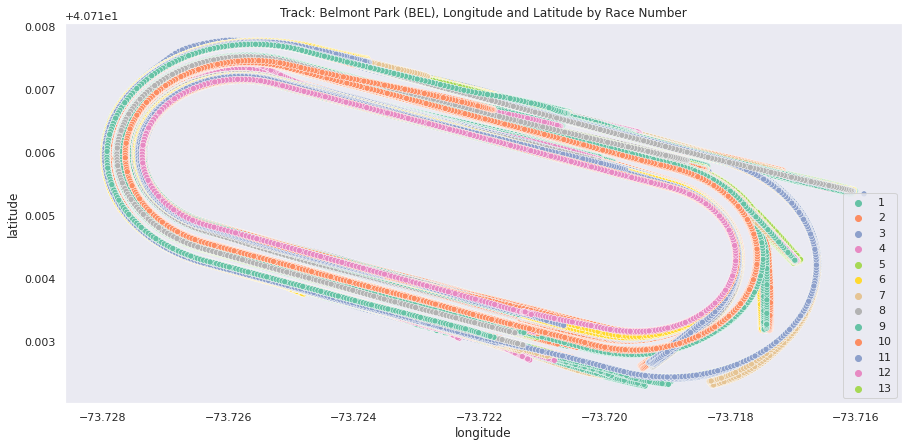

In [ ]:
# data - this one is sorted by race number
bel_track = tracking_table[tracking_table['track_id'] == "BEL"]
bel_track = bel_track[bel_track['month'] == 6]

# styling
fontsize = 12
plt.style.context('ggplot')
plt.figure(figsize = (15, 7))
sns.scatterplot(data = bel_track, x = "longitude", y = "latitude", hue = "race_number", palette = "Set2")

# plotting
plt.title("Track: Belmont Park (BEL), Longitude and Latitude by Race Number")
plt.grid()
plt.legend()

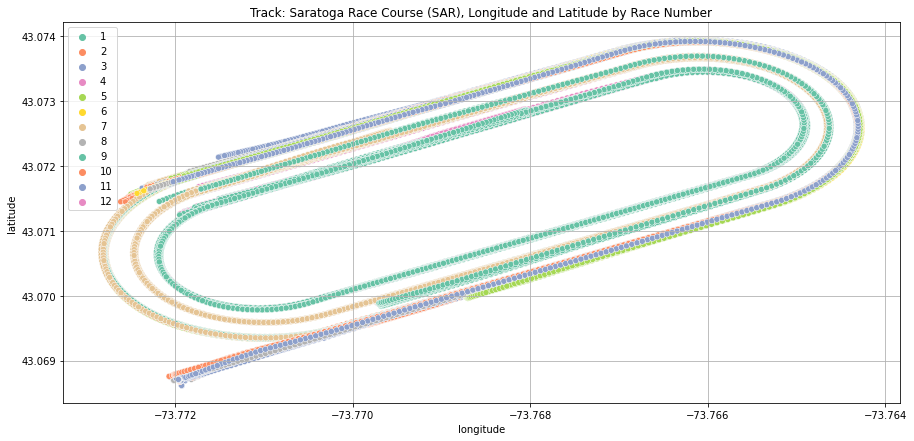

In [ ]:
# data
sar_track = tracking_table[tracking_table['track_id'] == "SAR"]
sar_track = sar_track[sar_track['month'] == 9]

# styling
fontsize = 12
plt.style.context('ggplot')
plt.figure(figsize = (15, 7))
sns.scatterplot(data = sar_track, x = "longitude", y = "latitude", hue = "race_number", palette = "Set2")

# plotting
plt.title("Track: Saratoga Race Course (SAR), Longitude and Latitude by Race Number")
plt.grid()
plt.legend()

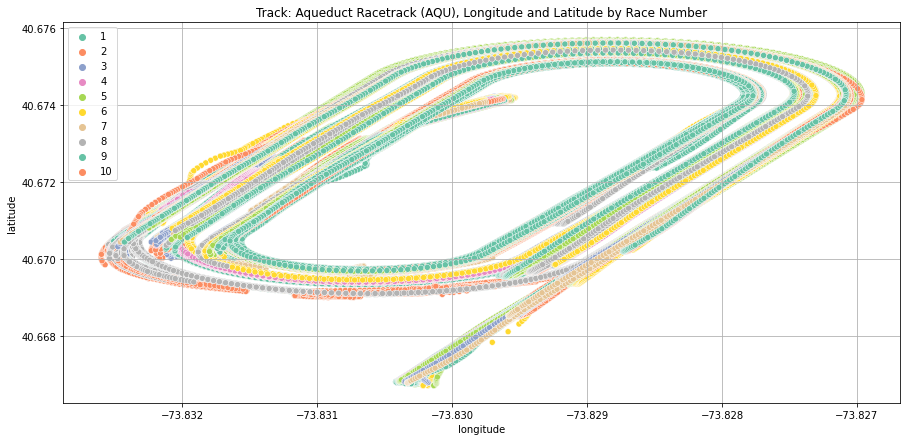

In [ ]:
# data
AQU_track = tracking_table[tracking_table['track_id'] == "AQU"]
AQU_track = AQU_track[AQU_track['month'] == 11]

# styling
font_size = 12
plt.style.context('ggplot')
plt.figure(figsize = (15, 7))
sns.scatterplot(data = AQU_track, x = "longitude", y = "latitude", hue = "race_number", palette = "Set2")

# plotting
plt.title("Track: Aqueduct Racetrack (AQU), Longitude and Latitude by Race Number", fontdict={'fontsize':font_size})
plt.grid()
plt.legend()

In [ ]:
# check unique program count (horse id)
start_table['program_number'].value_counts()

4      1748
3      1743
5      1731
2      1715
1      1708
6      1652
7      1390
8      1066
9       761
10      535
11      333
12      201
1A      164
13       77
14       44
15       24
2B       11
16       10
3X        1
1X        1
Name: program_number, dtype: int64

In [ ]:
# create plot for specific race on specific day 
bel_r1 = df[tracking_table['track_id'] == "BEL"]
bel_r1 = bel_r1[(bel_r1['race_number'] == 6) & (bel_r1['race_date']=='2019-06-09')]



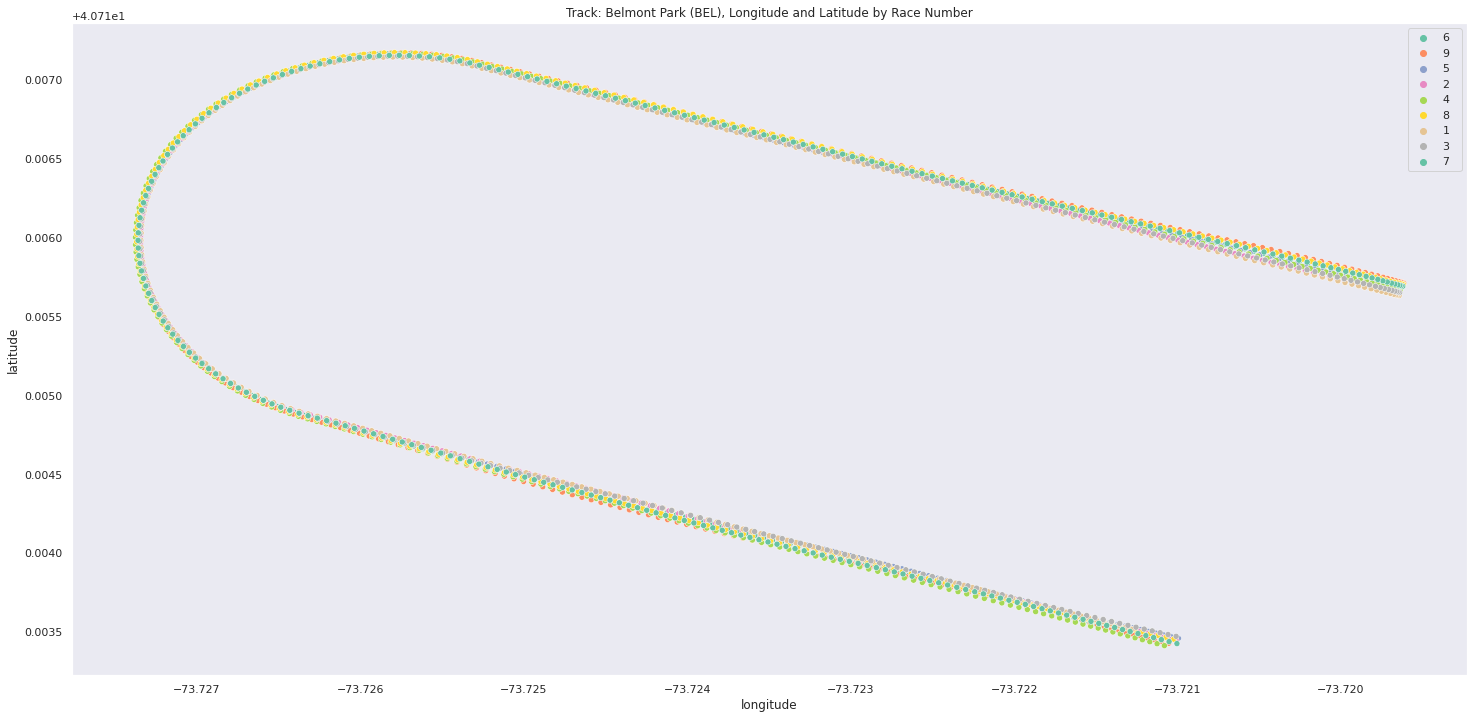

In [ ]:
# show race on specific day bel_r1 2019-06-09

# styling
fontsize = 12
plt.style.context('ggplot')
plt.figure(figsize = (25, 12))
sns.scatterplot(data = bel_r1, x = "longitude", y = "latitude", hue = "program_number", palette = "Set2")

# plotting
plt.title("Track: Belmont Park (BEL), Longitude and Latitude by Race Number")
plt.grid()
plt.legend()

In [ ]:
# we can compute race time with trakus_index (1 trakus = 0.25 seconds) - let's do it for the race we plotted above
track_id = "BEL"
race_date = "2019-06-09"
race_number = 6
target_tracking = df.query("track_id == @track_id & race_date == @race_date & race_number == @race_number").sort_values("trakus_index")
target_tracking

,track_id,race_date,race_number,program_number,trakus_index,latitude,longitude,distance_id,course_type,track_condition,run_up_distance,race_type,purse,post_time,weight_carried,jockey,odds,log_odds
845,BEL,2019-06-09,6,6,1,40.715684,-73.719632,600,I,FM,112,CLM,60000,412,123,Manuel Franco,1300,7.170888
1201072,BEL,2019-06-09,6,3,1,40.715651,-73.719642,600,I,FM,112,CLM,60000,412,123,Jose L. Ortiz,1690,7.433075
865361,BEL,2019-06-09,6,1,1,40.715632,-73.719645,600,I,FM,112,CLM,60000,412,123,Joel Rosario,1710,7.444833
129536,BEL,2019-06-09,6,5,1,40.715673,-73.719638,600,I,FM,112,CLM,60000,412,125,Eric Cancel,290,5.673323
377059,BEL,2019-06-09,6,4,1,40.715666,-73.719639,600,I,FM,112,CLM,60000,412,123,Luis Saez,720,6.580639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315573,BEL,2019-06-09,6,2,280,40.713448,-73.721009,600,I,FM,112,CLM,60000,412,123,Javier Castellano,335,5.817111
854,BEL,2019-06-09,6,6,280,40.713464,-73.721187,600,I,FM,112,CLM,60000,412,123,Manuel Franco,1300,7.170888
129545,BEL,2019-06-09,6,5,280,40.713462,-73.720995,600,I,FM,112,CLM,60000,412,125,Eric Cancel,290,5.673323
1805276,BEL,2019-06-09,6,7,280,40.713428,-73.721004,600,I,FM,112,CLM,60000,412,125,Dylan Davis,1190,7.082549


In [ ]:
dtime = 0.25 #0.25 second per trakus_index according to the data description.
#Elevations obtained from google earth
if track_id == "AQU":
    elevation = 3
elif track_id == "BEL":
    elevation = 20
elif track_id == "SAR":
    elevation = 93

target_trackings = []
for number, group in target_tracking.groupby("program_number"):
    ecef = np.array(pm.geodetic2ecef(group["latitude"].values, group["longitude"].values, np.array([elevation]*len(group)))).T
    #Calculate speed [km/h]
    v_ecef = np.sqrt(np.sum(np.diff(ecef,axis=0) ** 2, axis = 1)) * 3.6 / dtime
    group["time"] = group["trakus_index"] * dtime -  dtime
    group["speed"] = np.insert(v_ecef, 0, 0)
    target_trackings.append(group)
    print("No.", number," Mean speed : {:.2f} km/h".format(np.mean(v_ecef)))
target_tracking = pd.concat(target_trackings)
target_tracking

No. 1    Mean speed : 70.30 km/h
No. 2    Mean speed : 71.55 km/h
No. 3    Mean speed : 71.58 km/h
No. 4    Mean speed : 71.73 km/h
No. 5    Mean speed : 71.60 km/h
No. 6    Mean speed : 71.01 km/h
No. 7    Mean speed : 71.79 km/h
No. 8    Mean speed : 71.84 km/h
No. 9    Mean speed : 71.78 km/h


,track_id,race_date,race_number,program_number,trakus_index,latitude,longitude,distance_id,course_type,track_condition,run_up_distance,race_type,purse,post_time,weight_carried,jockey,odds,log_odds,time,speed
865361,BEL,2019-06-09,6,1,1,40.715632,-73.719645,600,I,FM,112,CLM,60000,412,123,Joel Rosario,1710,7.444833,0.00,0.000000
865362,BEL,2019-06-09,6,1,2,40.715635,-73.719656,600,I,FM,112,CLM,60000,412,123,Joel Rosario,1710,7.444833,0.25,13.438683
865363,BEL,2019-06-09,6,1,3,40.715637,-73.719665,600,I,FM,112,CLM,60000,412,123,Joel Rosario,1710,7.444833,0.50,11.538119
865364,BEL,2019-06-09,6,1,4,40.715640,-73.719677,600,I,FM,112,CLM,60000,412,123,Joel Rosario,1710,7.444833,0.75,15.587502
865365,BEL,2019-06-09,6,1,5,40.715645,-73.719699,600,I,FM,112,CLM,60000,412,123,Joel Rosario,1710,7.444833,1.00,27.988415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101202,BEL,2019-06-09,6,9,276,40.713476,-73.721228,600,I,FM,112,CLM,60000,412,125,Jose Lezcano,460,6.133398,68.75,57.487054
101193,BEL,2019-06-09,6,9,277,40.713465,-73.721186,600,I,FM,112,CLM,60000,412,125,Jose Lezcano,460,6.133398,69.00,54.462484
101194,BEL,2019-06-09,6,9,278,40.713454,-73.721142,600,I,FM,112,CLM,60000,412,125,Jose Lezcano,460,6.133398,69.25,55.874001
101195,BEL,2019-06-09,6,9,279,40.713442,-73.721099,600,I,FM,112,CLM,60000,412,125,Jose Lezcano,460,6.133398,69.50,55.815384


In [ ]:
%%time
# create new column of race_ids
cols = ["track_id", "race_date", "race_number"]

df['race_id'] = df[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
    


CPU times: user 1min 48s, sys: 2.33 s, total: 1min 50s
Wall time: 1min 54s


In [ ]:
%%time
# preparing for ord encoding to encode race_ids as single integer 
from sklearn.preprocessing import OrdinalEncoder
# define ordinal encoding
encoder = OrdinalEncoder()

ord_cols = ['race_id']

def ord_encoder(df, ord_cols):
  for column in ord_cols:
    # assign column to reshaped numpy array
    array = df[column].to_numpy()
    shaped = array.reshape(-1,1)
    #transform data 
    df[column] = encoder.fit_transform(shaped)
    print(df[column].head(n=5))
  return df

# encoding ordinal vars 
df = ord_encoder(df=df, ord_cols=ord_cols)

0    8.0
1    8.0
2    8.0
3    8.0
4    8.0
Name: race_id, dtype: float64


In [ ]:
# make em ints 
df['race_id'] = df['race_id'].astype(int)

In [ ]:
# 2000 unique races 
df['race_id'].nunique()

2000

In [ ]:
# data
Bel_purse_track = df[df['track_id'] == "BEL"]

# styling
font_size = 12
plt.style.context('ggplot')
plt.figure(figsize = (15, 7))
sns.scatterplot(data = Bel_purse_track, x = "purse", y = "odds", hue = "race_id", palette = "Set2")

# plotting
plt.title("odds vs. purse for races at Belmont", fontdict={'fontsize':font_size})
plt.grid()
plt.legend()

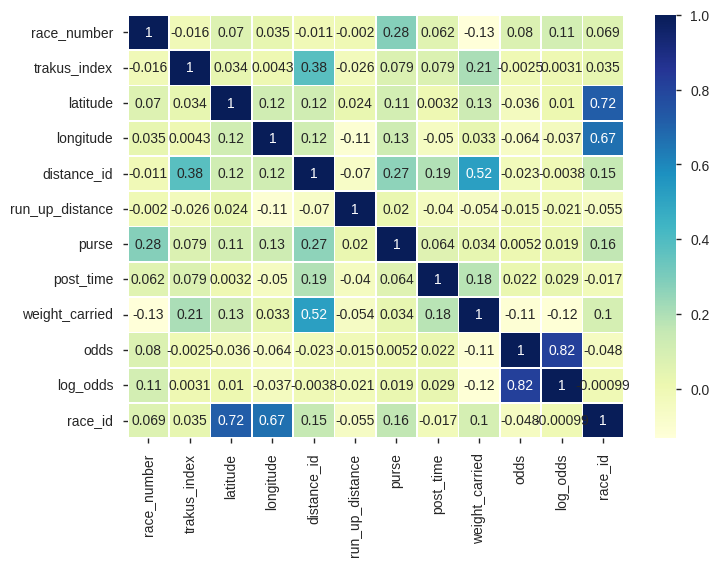

In [ ]:
# correlation heatmap
sns.color_palette('pastel')
dataplot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True, linewidths=.5)
dataplot

Credits: 

Track visualization & speed inspiration from Matt's notebook @ https://www.kaggle.com/code/mattop/big-data-derby-2022-eda

Speed and time tracking from Roni's notebook @ https://www.kaggle.com/code/roniheka/obtain-time-course-of-speed-during-a-race

